# BE SUR LA METHODE DES VOLUMES FINIS (2021-2022) #

### Groupe : PC1
### Nom : Shan / Creelle
### Prénom : Louis / Robbe

## Informations pratiques ##

**Modalités pédagogiques** 

**Évaluation du BE**

L'évaluation du BE se basera **uniquement** sur le Notebook (fichier .ipynb) que vous devrez rendre sur le LMS avant le **14/01/2022, 12h00** au plus tard, ici : https://lms.isae.fr/course/view.php?id=1280#section-5

**Fonctionnement dans le contexte COVID-19**

Afin de simplifier les aspects techniques et informatiques, ce BE peut se faire à l'aide de l'outil gratuit en ligne Google Colab. Il est alors **nécessaire d'avoir un compte Google**.

* Créer son compte Google : 
    https://accounts.google.com/signup
* Google Colab : 
    https://colab.research.google.com/notebooks/ puis choisir **importer**
    
**Contact:** ghislain.haine@isae.fr

## Nota Bene ##

Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Le rendu sera **uniquement** ce fichier Notebook complété dans lequel vous devez insérer l'ensemble de vos résultats et commentaires. 


## Phénomènes de transport ##

L'objectif de ce BE est l'étude qualitative des schémas numériques usuels pour d'une part la résolution de l'équation de transport linéaire monodimensionnelle :
$$
\dfrac{\partial u}{\partial t} + a \dfrac{\partial u}{\partial x} = 0,
$$
où $a$ est une constante, et d'autre part celle de l'équation de transport non linéaire, dite équation de Burgers :
$$
\dfrac{\partial u}{\partial t} + \dfrac12 \dfrac{\partial u^2}{\partial x} = 0.
$$

Les phénomènes convectifs jouent un rôle fondamental dans de très nombreux processus d'origine naturelle ou industrielle. Les équations précédentes en constituent les modèles les plus simples mais néanmoins génériques. Le développement de schémas numériques efficaces pour ces deux équations est donc une étape essentielle dans la construction de schémas plus complexes adaptés à la résolution des systèmes d'équations non linéaires, intervenant en mécanique des fluides par exemple.


Afin de faciliter l'étude, on suppose que la variable $x$ prend ses valeurs dans l'intervalle $(0,1)$ et on considère la condition de périodicité :
$$
u(t,0) = u(t,1), \qquad \forall t \ge 0.
$$
On ajoute ensuite une donnée initiale :
$$
u(0,x) = u_0(x), \qquad \forall x \in (0,1), \qquad u_0(1)=u_0(0).
$$

### Discrétisation ###

On note $\Delta x$ le pas de discrétisation spatiale et $\Delta t$ le pas de discrétisation temporelle. On pose $\Delta x = \dfrac{1}{J}$ où $J$ désigne le nombre d'intervalles de discrétisation de l'intervalle $[0,1]$. On note $u_j^n$ la valeur de la solution discrète dans la cellule $j$ à l'instant $t^n = n \Delta t$ ($\Omega_j^n$ de la PC) et on considère le schéma aux volumes finis :
$$
u_j^{n+1} = u_j^n - \dfrac{\Delta t}{\Delta x} \left[ g_{j+\frac12}^n - g_{j-\frac12}^n \right], \qquad \forall 1\le j \le J,
$$
où, pour l'expression du flux numérique $g$, on considérera plusieurs cas correspondant à différents schémas. Pour ces schémas, on tiendra compte de la condition de périodicité en posant :
$$
u_0^n = u_J^n, \quad u_{-1}^n = u_{J-1}^n, \quad u_{J+1}^n = u_1^n, \quad u_{J+2}^n = u_2^n.
$$


In [2]:
########################
# INITIALISATION DU BE #
########################
#
# [A LANCER SANS MODIFICATION]
#

# Chargement des bibliotheques

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# Methodes d'integration temporelle et spatiale pour les equations de transport lineaire

def solution_exacte_transport(a, J, lambda_s, tf, x, Donnee_initiale_discontinue):
    """
    Schema decentre du premier ordre pour l'integration de l'equation de transport
    lineaire monodimensionnelle
    
    Input: 
    a : constante representant la vitesse de convection [float]
    J : nombre d'intervalles de discretisation en espace dans l'intervalle d'etude [int]
    lambda_s : constante reliant le pas d'espace et le pas de temps [float]
    tf : temps final [float]
    x  : champ initial [Numpy array]
    Donnee_initiale_discontinue: booleen specifiant le type de donnees initiales
        
    Output:
    U: Tableau comportant les solutions a chaque instant  [Numpy array]
    time : Temps discrets sur l'intervalle [0, tf][Numpy array]
    """
    
    # Pas de discretisation en espace et en temps
    dx = 1.0/float(J)
    dt = lambda_s * dx / abs(a)
    
    # Nombre d'iterations en temps
    N = int(np.ceil(tf/dt)) + 1
 
    # Initialisation
    U      = np.zeros(shape=(len(x),N))
    time   = np.zeros(N)
    
    if Donnee_initiale_discontinue == False:
        for n in range(N):
            t = time[n]
            U[:,n] = (np.sign(np.mod((x - a * t),1) - 0.25) + \
                      np.sign(0.75 - np.mod((x - a * t),1)))/2. * \
                      (256 * (np.mod((x - a * t),1) - 0.25)**2 * \
                      (np.mod((x - a * t),1) - 0.75)**2)
            if n < N-1:
                time[n+1] = time[n] + dt
    else:
        for n in range(N):
            t = time[n]
            U[:,n] = (np.sign(np.mod((x - a * t),1) - 0.25) + \
                       np.sign(0.75 - np.mod((x - a * t),1)))/2. 
            if n < N-1:
                time[n+1] = time[n] + dt
                  
    return U, time


## Exercice 1 : Schémas numériques pour l'équation de transport linéaire ##

Dans cette première partie, on considère le système :
$$
\left\lbrace
\begin{array}{rl}
\dfrac{\partial u}{\partial t} + a \dfrac{\partial u}{\partial x} = 0,&\qquad \forall t \ge 0, \forall x \in (0,1),\\
u(t,0) = u(t,1), &\qquad \forall t \ge 0,\\
u(0,x) = u_0(x), &\qquad \forall x \in (0,1), \qquad u_0(1)=u_0(0).
\end{array}\right.
$$

L'objectif est de calculer numériquement la solution de ce système par trois schémas aux volumes finis différents et de les comparer à la solution théorique.


### Question 1 ###

Quelle est la solution théorique du problème précédent ?

Réponse : La solution est donnée par u(t,x) = u0(x-at), pour tout x dans [0, 1] et t positif


### Question 2 ###

Complétez la fonction `schema1` correspondant au schéma décentré de premier ordre, c'est-à-dire le schéma aux volumes finis avec le flux numérique :

$$
g_{j+\frac12}^n = \max(a,0)~u_j^n + \min(a,0)~u_{j+1}^n.
$$

In [1]:
###################################
# TRANSPORT LINEAIRE - Exercice 1 #
###################################
#
# Question 2 [A COMPLETER]
#

def schema1(a, J, lambda_s, tf, U0):
    """
    Schema decentre du premier ordre pour l'integration de l'equation de transport
    lineaire monodimensionnelle
    
    Input: 
    a : constante representant la vitesse de convection [float]
    J : nombre d'intervalles de discretisation en espace dans l'intervalle d'etude [int]
    lambda_s : constante reliant le pas d'espace et le pas de temps [float]
    tf : temps final [float]
    U0 : champ initial [Numpy array]
        
    Output:
    U: Tableau comportant les solutions a chaque instant  [Numpy array]
    time : Temps discrets [Numpy array]
    """
    
    # Pas de discretisation en espace et en temps
    dx = 1.0/float(J)
    dt = lambda_s * dx / abs(a)
    
    # Coefficients apparaissants dans le schema
    amin = (1-np.sign(a))/2.
    amax = (1+np.sign(a))/2.
     
    # Nombre d'iterations en temps
    N = int(np.ceil(tf/dt)) + 1
 
    # Initialisation
    U      = np.zeros(shape=(len(U0),N))
    U[:,0] = U0[:]
    Up     = np.zeros(len(U0))
    Um     = np.zeros(len(U0))
    time   = np.zeros(N)
    
    # A COMPLETER debut
        
    g_plus = np.zeros(len(U0))
    g_moins = np.zeros(len(U0))
    
    for k in range (N-1):
        Up[0:J-1] = U[1:,k]
        Up[J-1] = U[0,k]
    
        Um[1:] = U[0:J-1,k]
        Um[0] = U[J-1,k]
        
        g_plus = amax*U[:,k] + amin*Up[:]
        g_moins = amax*Um[:] + amin*U[:,k]
        
        U[:,k+1] = U[:,k]-dt*abs(a)/dx*(g_plus-g_moins)
        
    # A COMPLETER fin
                  
    return U, time



#
# Fin question 2
#

### Question 3 ###

Complétez la fonction `schema2` correspondant au schéma décentré du second ordre, c'est-à-dire le schéma aux volumes finis avec le flux numérique :

$$
g_{j+\frac12}^n = \max(a,0) \left[u_j^n + \frac14 (1-\lambda)(u_{j+1}^n-u_{j-1}^n)\right] + \min(a,0) \left[u_{j+1}^n - \frac14(1-\lambda)(u_{j+2}^n-u_j^n) \right].
$$

In [4]:
###################################
# TRANSPORT LINEAIRE - Exercice 1 #
###################################
#
# Question 3 [A COMPLETER]
#

def schema2(a, J, lambda_s, tf, U0):
    """
    Schema decentre du second ordre pour l'integration de l'equation de transport
    lineaire monodimensionnelle
    
    Input: 
    a : constante representant la vitesse de convection [float]
    J : nombre d'intervalles de discretisation en espace dans l'intervalle d'etude [int]
    lambda_s : constante reliant le pas d'espace et le pas de temps [float]
    tf : temps final [float]
    U0 : champ initial [Numpy array]
        
    Output:
    U: champ a l'instant final tf [Numpy array]
    time : Temps discrets [Numpy array]
    """
    
    # Pas de discretisation en espace et en temps
    dx = 1.0/float(J)
    dt = lambda_s * dx / abs(a)
    
    # Coefficients apparaissants dans le schema
    amin = (1-np.sign(a))/2.
    amax = (1+np.sign(a))/2.
    
    # Nombre d'iterations en temps
    N = int(np.ceil(tf/dt)) + 1
    
    # Initialisation
    U      = np.zeros(shape=(len(U0),N))
    U[:,0] = U0[:]
    Up     = np.zeros(shape=(len(U0),))
    Um     = np.zeros(shape=(len(U0),))
    Upp    = np.zeros(shape=(len(U0),))
    Umm    = np.zeros(shape=(len(U0),))
    time   = np.zeros(N)
    
    # A COMPLETER debut
    
    g_plus = np.zeros(len(U0))
    g_moins = np.zeros(len(U0))
    
    for k in range (N-1):
        Up[0:J-1] = U[1:,k]
        Up[J-1] = U[0,k]
    
        Um[1:] = U[0:J-1,k]
        Um[0] = U[J-1,k]
        
        Upp[0:J-1] = Up[1:]
        Upp[J-1] = Up[0]
        
        Umm[1:] = Um[0:J-1]
        Umm[0] = Um[J-1]
        
        g_plus = amax*(U[:,k]+0.25*(1-lambda_s)*(Up[:]-Um[:])) + amin*(Up[:]-0.25*(1-lambda_s)*(Upp[:]-U[:,k]))
        g_moins = amax*(Um[:]+0.25*(1-lambda_s)*(U[:,k]-Umm[:])) + amin*(U[:,k]-0.25*(1-lambda_s)*(Up[:]-Um[:]))
        
        U[:,k+1] = U[:,k]-dt*abs(a)/dx*(g_plus-g_moins)
    
        
    # A COMPLETER fin
        
    return U, time

#
# Fin question 3
#

### Question 4 ###

Complétez la fonction `schemaLW` correspondant au schéma de Lax-Wendroff, c'est-à-dire le schéma aux volumes finis avec le flux numérique :

$$
g_{j+\frac12}^n = \frac{a}{2} (u_j^n+u_{j+1}^n) - \frac{|a|\lambda}{2} (u_{j+1}^n-u_j^n).
$$

In [5]:
###################################
# TRANSPORT LINEAIRE - Exercice 1 #
###################################
#
# Question 4 [A COMPLETER]
#

def schemaLW(a, J, lambda_s, tf, U0):
    """
    Schema de Lax-Wendroff pour l'integration de l'equation de transport
    lineaire monodimensionnelle
    
    Input: 
    a : constante representant la vitesse de convection [float]
    J : nombre d'intervalles de discretisation en espace dans l'intervalle d'etude [int]
    lambda_s : constante reliant le pas d'espace et le pas de temps [float]
    tf : temps final [float]
    U0 : champ initial [Numpy array]
        
    Output:
    U: champ a l'instant final tf [Numpy array]
    time : Temps discrets [Numpy array]
    """
    # Pas de discretisation en espace et en temps
    dx = 1.0/float(J)
    dt = lambda_s * dx / abs(a)
        
    # Nombre d'iterations en temps
    N = int(np.ceil(tf/dt)) + 1
 
    # Initialisation
    U      = np.zeros(shape=(len(U0),N))
    U[:,0] = U0[:]
    Up     = np.zeros(shape=(len(U0),))
    Um     = np.zeros(shape=(len(U0),))
    time   = np.zeros(N)
    
    # A COMPLETER debut
    
    g_plus = np.zeros(len(U0))
    g_moins = np.zeros(len(U0))
    
    for k in range (N-1):
        Up[0:J-1] = U[1:,k]
        Up[J-1] = U[0,k]
    
        Um[1:] = U[0:J-1,k]
        Um[0] = U[J-1,k]
        
        g_plus = a/2*(U[:,k] + Up[:]) - abs(a)*lambda_s*0.5*(Up[:]-U[:,k])
        g_moins = a/2*(Um[:] + U[:,k]) - abs(a)*lambda_s*0.5*(U[:,k]-Um[:])
        
        U[:,k+1] = U[:,k]-dt/dx*(g_plus-g_moins)
        
    # A COMPLETER fin
        
    return U, time

#
# Fin question 4
#



### Question 5 ###

Complétez `driver_mvf_transport` pour initialiser le vecteur $U_0$ correspondant à la donnée initiale :

$$
u_0(x) = 256\left(x-\frac14\right)^2\left(x-\frac34\right)^2\chi(x),
$$
où $\chi$ est la fonction indicatrice de l'intervalle $[\frac{1}{4}, \frac{3}{4}]$.

In [49]:
###################################
# TRANSPORT LINEAIRE - Exercice 1 #
###################################
#
# Question 5 [A COMPLETER]
#

def driver_mvf_transport(a,J,lambda_s,tf,Donnee_initiale_discontinue=False):
    """
    a              # Vitesse de propagation
    J              # Nombre d'intervalles de discrétisation en espace
    lambda_s       # Nombre CFL = a * dt / dx
    tf             # Temps final
    Donnee_initiale_discontinue # Booleen
    """
    
    plt.cla()
    plt.clf()
    plt.close("all")    

    # Discrétisation en espace

    dx       = 1./float(J)
    x        = np.linspace(0,1,J,endpoint=False) # En 1, on reprend la valeur en 0 !

    # Construction de la fonction indicatrice Chi

    Chi      = (np.sign(x - 0.25) + np.sign(0.75 - x))/2.

    # Initialisation en fonction du type de donnee initiale

    if Donnee_initiale_discontinue == False:
        
        # A COMPLETER debut
        
        U0 = 256*(x-0.25)**2*(x-0.75)**2*Chi
        
        # A COMPLETER fin
        
        my_label_discontinuite = 'sans'
    else:
        U0 = Chi[:]  # Donnée initiale discontinue
        my_label_discontinuite = 'avec'

##
## ÉQUATION DE TRANSPORT
##

    num = 0

    # Solution exacte  en fonction du type de donnee initiale

    UE, time  = solution_exacte_transport(a, J, lambda_s, tf, x, Donnee_initiale_discontinue)

    # Solutions numériques pour les trois schémas d'integration

    U1, time  = schema1(a,  J, lambda_s, tf, U0)
    U2, time  = schema2(a,  J, lambda_s, tf, U0)
    ULW, time = schemaLW(a, J, lambda_s, tf, U0)

    #
    # Affichage des solutions autemps final sur un même graphique
    # 
    num += 1
    fig  = plt.figure(num)
    plt.plot(x, UE[:,-1], '-',x, U1[:,-1], 'x', x, U2[:,-1], 's', x, ULW[:,-1],' *')
    plt.title('Transport: Comparaison des solutions au temps final = ' + \
              '{:8.8}'.format(str(time[-1])))
    plt.legend(['Solution exacte', 'Schéma 1', 'Schéma 2', 'Schéma Lax Wendroff'],loc='best')
    plt.grid(True)
    title    = 'MVF_Solution_Transport_CFL='+str(lambda_s)+ "_" + \
                my_label_discontinuite+"_donnee_initiale_discontinue.png"
    plt.show()
    fig.savefig(title)


    #
    # Creation de l'animation
    #
    num     += 1
    fig      = plt.figure(num)
    my_title = 'Comparaison des solutions pour le probleme de transport '
    my_title = my_title + my_label_discontinuite + " donnee initiale discontinue"
    metadata = dict(title = my_title, artist='Matplotlib', comment='BE VF Deuxieme annee')
    writer   = FFMpegWriter(fps=5, metadata=metadata)
    title    = 'MVF_Solution_Transport_CFL='+str(lambda_s)+ "_" + \
                my_label_discontinuite+"_donnee_initiale_discontinue.mp4"
    wframe   = None

    with writer.saving(fig, title, 200):
        print("Creation de l'animation pour le probleme de transport")
        for m in range(len(time)):
            plt.title('Equation de transport monodimensionnelle')
            plt.xlabel('x')
            plt.ylabel('Solution')
            plt.ylim(min(np.min(U2),np.min(U1))-0.1, 1.1* max(np.max(U1),np.max(U2)))
            plt.plot(x,UE[:,m],x,U1[:,m],'-',x,U2[:,m],'-',x,ULW[:,m],animated=True)
            plt.legend(['Solution exacte','Schéma 1', 'Schéma 2', 'Schéma Lax Wendroff'],loc='best')
            plt.title('Instant= '+'{:5.5}'.format(str(time[m]))+' s')
            plt.grid(True)
            writer.grab_frame()
            plt.clf()
        print("Fin de la creation du fichier: "+ title)   
def driver_mvf_transport2(a,J,lambda_s,tf,Donnee_initiale_discontinue=False):
    """
    a              # Vitesse de propagation
    J              # Nombre d'intervalles de discrétisation en espace
    lambda_s       # Nombre CFL = a * dt / dx
    tf             # Temps final
    Donnee_initiale_discontinue # Booleen
    """
    
    plt.cla()
    plt.clf()
    plt.close("all")    

    # Discrétisation en espace

    dx       = 1./float(J)
    x        = np.linspace(0,1,J,endpoint=False) # En 1, on reprend la valeur en 0 !

    # Construction de la fonction indicatrice Chi

    Chi      = (np.sign(x - 0.25) + np.sign(0.75 - x))/2.

    # Initialisation en fonction du type de donnee initiale

    if Donnee_initiale_discontinue == False:
        
        # A COMPLETER debut
        
        U0 = 256*(x-0.25)**2*(x-0.75)**2*Chi
        
        # A COMPLETER fin
        
        my_label_discontinuite = 'sans'
    else:
        U0 = Chi[:]  # Donnée initiale discontinue
        my_label_discontinuite = 'avec'

##
## ÉQUATION DE TRANSPORT
##

    num = 0

    # Solution exacte  en fonction du type de donnee initiale

    UE, time  = solution_exacte_transport(a, J, lambda_s, tf, x, Donnee_initiale_discontinue)

    # Solutions numériques pour les trois schémas d'integration

    U1, time  = schema1(a,  J, lambda_s, tf, U0)
    U2, time  = schema2(a,  J, lambda_s, tf, U0)
    ULW, time = schemaLW(a, J, lambda_s, tf, U0)

    #
    # Affichage des solutions autemps final sur un même graphique
    # 
    num += 1
    fig  = plt.figure(num)
    plt.plot(x, UE[:,-1], '-',x, U1[:,-1], 'x', x, U2[:,-1], 's', x, ULW[:,-1],' *')
    plt.title('Transport: Comparaison des solutions au temps final = ' + \
              '{:8.8}'.format(str(time[-1])))
    plt.legend(['Solution exacte', 'Schéma 1', 'Schéma 2', 'Schéma Lax Wendroff'],loc='best')
    plt.grid(True)
    title    = 'MVF_Solution_Transport_CFL='+str(lambda_s)+ "_" + \
                my_label_discontinuite+"_donnee_initiale_discontinue.png"
    plt.show()   
            
def driver_mvf_transport3(a,J,lambda_s,tf,Donnee_initiale_discontinue=False):
    """
    a              # Vitesse de propagation
    J              # Nombre d'intervalles de discrétisation en espace
    lambda_s       # Nombre CFL = a * dt / dx
    tf             # Temps final
    Donnee_initiale_discontinue # Booleen
    """
    
    plt.cla()
    plt.clf()
    plt.close("all")    

    # Discrétisation en espace

    dx       = 1./float(J)
    x        = np.linspace(0,1,J,endpoint=False) # En 1, on reprend la valeur en 0 !

    # Construction de la fonction indicatrice Chi

    Chi      = (np.sign(x - 0.25) + np.sign(0.75 - x))/2.

    # Initialisation en fonction du type de donnee initiale

    if Donnee_initiale_discontinue == False:
        
        # A COMPLETER debut
        
        U0 = 256*(x-0.25)**2*(x-0.75)**2*Chi
        
        # A COMPLETER fin
        
        my_label_discontinuite = 'sans'
    else:
        U0 = Chi[:]  # Donnée initiale discontinue
        my_label_discontinuite = 'avec'

##
## ÉQUATION DE TRANSPORT
##

    num = 0

    # Solution exacte  en fonction du type de donnee initiale

    UE, time  = solution_exacte_transport(a, J, lambda_s, tf, x, Donnee_initiale_discontinue)

    # Solutions numériques pour les trois schémas d'integration

    U1, time  = schemaLW(a,  J, lambda_s, tf, U0)
    U2, time  = schemaLW(a,  J, lambda_s, tf, U0)
    ULW, time = schemaLW(a, J, lambda_s, tf, U0)

    #
    # Affichage des solutions autemps final sur un même graphique
    # 
    num += 1
    fig  = plt.figure(num)
    plt.plot(x, UE[:,-1], '-',x, U1[:,-1], 'x', x, U2[:,-1], 's', x, ULW[:,-1],' *')
    plt.title('Transport: Comparaison des solutions au temps final = ' + \
              '{:8.8}'.format(str(time[-1])))
    plt.legend(['Solution exacte', 'Schéma Lax Wendroff', 'Schéma Lax Wendroff', 'Schéma Lax Wendroff'],loc='best')
    plt.grid(True)
    title    = 'MVF_Solution_Transport_CFL='+str(lambda_s)+ "_" + \
                my_label_discontinuite+"_donnee_initiale_discontinue.png"
    plt.show()   
#
# Fin question 5
#

### Question 6 ###

Utiliser `driver_mvf_transport` pour obtenir une figure comprenant la solution exacte ainsi que les trois approximations correspondant aux trois schémas. Vous pourrez également visualiser l'évolution temporelle des solutions sur 0.5 secondes en cliquant sur le nom du fichier créé sur la page d'accueil de Jupyter.

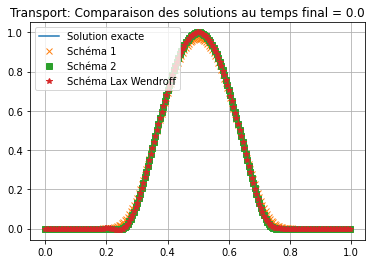

Creation de l'animation pour le probleme de transport
Fin de la creation du fichier: MVF_Solution_Transport_CFL=0.8_sans_donnee_initiale_discontinue.mp4


<Figure size 432x288 with 0 Axes>

In [ ]:
###################################
# TRANSPORT LINEAIRE - Exercice 1 #
###################################
#
# Question 6 [A COMPLETER]
#

a        = 2.       # Vitesse de propagation
J        = 200      # Nombre d'intervalles de discrétisation en espace
lambda_s = 0.8      # Nombre CFL = a * dt / dx
tf       = 0.5      # Temps final

# A COMPLETER debut

driver_mvf_transport(a,J,lambda_s,tf,Donnee_initiale_discontinue=False)

# A COMPLETER fin

#
# Fin question 6
#

### Question 7 ###

Reprendre les trois questions précédentes avec $u_0(x)=\chi(x)$ cette fois.

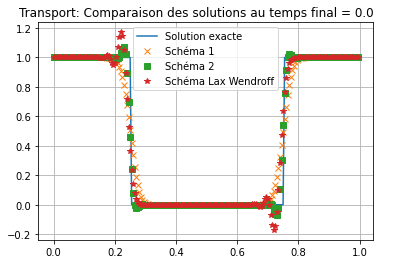

Creation de l'animation pour le probleme de transport
Fin de la creation du fichier: MVF_Solution_Transport_CFL=0.8_avec_donnee_initiale_discontinue.mp4


<Figure size 432x288 with 0 Axes>

In [ ]:
###################################
# TRANSPORT LINEAIRE - Exercice 1 #
###################################
#
# Question 7 [A COMPLETER]
#

a        = 1.       # Vitesse de propagation
J        = 200      # Nombre d'intervalles de discrétisation en espace
lambda_s = 0.8      # Nombre CFL = a * dt / dx
tf       = 0.5      # Temps final
Donnee_initiale_discontinue = True

# A COMPLETER debut

driver_mvf_transport(a,J,lambda_s,tf,Donnee_initiale_discontinue)

# A COMPLETER fin

#
# Fin question 7
#

### Question 8 ###

#### A) Vous commenterez les résultats obtenus, en jouant sur les paramètres $a$, $J$, $\lambda$ et $t_f$.  ####

Réponse :Les paramètres $a$, $J$, $\lambda$ peuvent être regrouper dans le nombre CFL. Ensuite, il y a l'influence de $t_f$. L'erreur par rapport à la solution est plus grande lorsuqe $t_f$ augmente etant donné les erreurs numeriques et de diffusion qui augmente car plus d'itteration (Voir ci-dessus 8.a). 

Deuxiement, en augmentant le CFL, les schémas deviennent instables. Cette limite est montrée sur les images ce-dessous.Le pas de temps est trop grand par rapport à la discretisation

#### B) Quelle est l'influence de la CFL $\lambda$ à $\Delta x$ fixé ? ####

Réponse : Les schémas deviennent instables au-delà d'un certain CFL. la limite de stabilité est fixée à 1 ($0,8\cdot 1,25$).
#### C) Le comportement numérique des solutions est-il correct lorsque $a$ est négatif ? ####

Réponse : Marche que avec le schéma de Lax-Wendroff comme le montre la dernière figure ci-dessous. Pour les autres schémas, non.


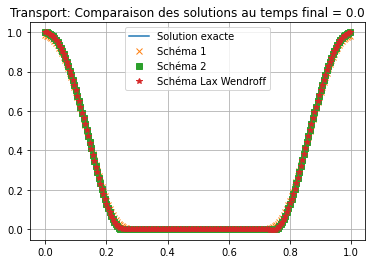

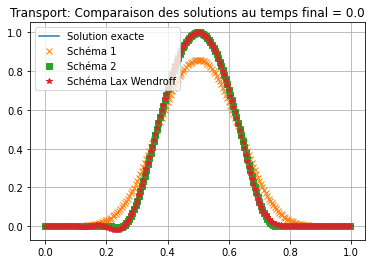

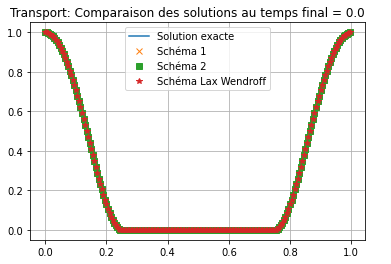

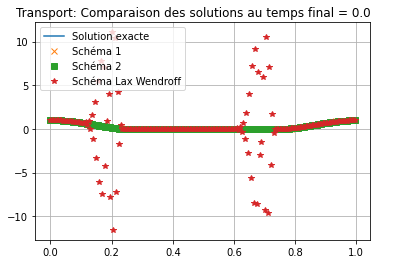

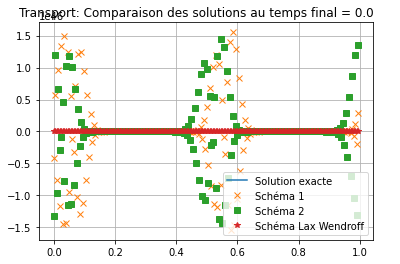

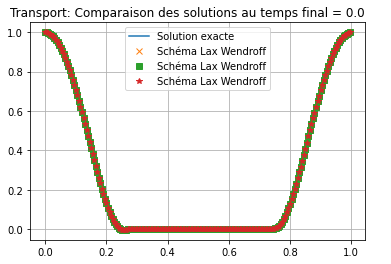

In [50]:
###################################
# Illustration question 8 #
###################################
#
# Question 8 
#

a        = 1.       # Vitesse de propagation
J        = 200      # Nombre d'intervalles de discrétisation en espace
lambda_s = 0.8     # Nombre CFL = a * dt / dx
tf       = 0.5      # Temps final


# A 8.a)

driver_mvf_transport2(a,J,lambda_s,tf,False)

# tf plus grand
driver_mvf_transport2(a,J,lambda_s,10*tf,False)

#limite de stabilité de CFL 8.a)
driver_mvf_transport2(a,J,lambda_s*1.25,tf,False)
driver_mvf_transport2(a,J,lambda_s*1.3,tf,False)


# 8.c) a negatif 
driver_mvf_transport2(-a,J,lambda_s,tf,False)
driver_mvf_transport3(-a,J,lambda_s,tf,False)#lax wendroff seulement


#
# Fin question 7
#

## Exercice 2 : Schémas numériques pour l'équation de Burgers ##

L'objectif de cette partie est d'illustrer les problèmes spécifiques liés à l'approximation de problèmes hyperboliques **non linéaires**. Pour cela, on va considérer le système :
$$
\left\lbrace
\begin{array}{rl}
\dfrac{\partial u}{\partial t} + \dfrac12 \dfrac{\partial u^2}{\partial x} = 0,&\qquad \forall t \ge 0, \forall x \in (0,1),\\
u(t,0) = u(t,1), &\qquad \forall t \ge 0,\\
u(0,x) = u_0(x), &\qquad \forall x \in (0,1), \qquad u_0(1)=u_0(0).
\end{array}\right.
$$

et le résoudre numériquement par un schéma *naïf*, puis à l'aide du schéma de Godounov étudié lors de la [PC 1&2](https://lms.isae.fr/mod/resource/view.php?id=35841) ([corrigé](https://lms.isae.fr/mod/resource/view.php?id=35842)).

On supposera dans toute la suite **la donnée initiale positive**.

### Question 1 ### 

Complétez la fonction `upwind` correspondant au schéma *naïf* suivant :

Si l'on suppose que la solution $u$ de l'équation de Burgers est régulière, alors $u$ est solution de
$$
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} = 0.
$$
On peut alors, en raisonnant par analogie, voir cette équation comme une équation de transport avec pour vitesse de convection *variable* la fonction $u$ elle-même. Toujours par analogie, on peut adapter le schéma décentré d'ordre 1 `schema1` en remplaçant $a$ par $u_j^n$.


In [51]:
#####################################
# EQUATIONS DE BURGERS - Exercice 2 #
#####################################
#
# Question 1 [A COMPLETER]
#

def upwind(J, lambda_s, tf, U0):
    """
    Schema upwind pour l'integration de l'equation de l'equation de Burgers
    
    Input: 
    J : nombre d'intervalles de discretisation en espace dans l'intervalle d'etude [int]
    lambda_s : constante reliant le pas d'espace et le pas de temps [float]
    tf : temps final [float]
    U0 : champ initial [Numpy array]
        
    Output:
    U: champ a l'instant final tf [Numpy array]   
    time : Temps discrets [Numpy array] 
    """ 
    
    # Pas de discretisation en espace et en temps
    dx     = 1.0/float(J)
    dt     = lambda_s * dx
        
    # Nombre d'iterations en temps
    N      = int(np.ceil(tf/dt)) + 1
    
    # Initialisation
    U      = np.zeros(shape=(len(U0),N))
    U[:,0] = U0[:]
    Um     = np.zeros(shape=(len(U0),))
    Um[:]  = U0[:] 
    Up     = np.zeros(shape=(len(U0),))
    Up[:]  = U0[:] 
    time   = np.zeros(N)
    
    # A COMPLETER debut
    
    g_plus = np.zeros(len(U0))
    g_moins = np.zeros(len(U0))
    amin = np.zeros(len(U0))
    amax = np.zeros(len(U0))
    
    for k in range(N-1):

        for i in range(J):
          amin[i] = min([0,U[i,k]])
          amax[i] = max([0,U[i,k]])
        
        Up[0:J-1] = U[1:,k]
        Up[J-1] = U[0,k]
    
        Um[1:] = U[0:J-1,k]
        Um[0] = U[J-1,k]
        
        g_plus = amax*U[:,k] + amin*Up[:]
        g_moins = amax*Um[:] + amin*U[:,k]
        
        U[:,k+1] = U[:,k]-dt/dx*(g_plus-g_moins)
    
    # A COMPLETER fin
    
    return U, time

#
# Fin question 1
#

### Question 2 ### 

Complétez la fonction `godounov` correspondant au schéma de Godounov étudié dans la [PC 1&2](https://lms.isae.fr/mod/resource/view.php?id=35841) ([corrigé](https://lms.isae.fr/mod/resource/view.php?id=35842)).

En particulier, il vous faudra compléter la fonction `riemann` qui calcule la solution du problème de Riemann $u(t,x)={\bf{u}}(x/t,u_g,u_d)$, pour l'utiliser dans la méthode `godounov`.


In [52]:
#####################################
# EQUATIONS DE BURGERS - Exercice 2 #
#####################################
#
# Question 2 [A COMPLETER]
#

def riemann(xt,ul,ur):
    """
    Calcul de la solution analytique du probleme de Riemann
    
    Input:
    xt : x/t [float]
    ul : valeur du champ scalaire a gauche de l'interface [float]
    ur : valeur du champ scalaire a droite de l'interface [float]
    
    Output:
    y : solution du probleme de Riemann [float]
    
    """  
    y = ul
    
    # A COMPLETER debut
    
    if ul > ur:   # Cas onde de choc
        if xt > (ul+ur)/2:
            y = ur
        else:
            y = ul
    elif ul < ur: # Cas onde de rarefaction
        if xt > ur:  # on est a droite de la caracteristique "de droite"
            y = ur
        elif xt < ul: # on est a gauche de la caracteristique "de gauche"
            y = ul
        else:        # on est dans la zone centrale, solution particuliere
            y = xt
            
    # A COMPLETER fin

    return y

#
#   
#

def godounov(J, lambda_s, tf, U0):
    """
    Schema de Godounov pour l'integration temporelle de l'equation de Burgers
    
    Input: 
    J : nombre de points de discretisation en espace dans l'intervalle d'etude  [int]
    lambda_s : constante reliant le pas d'espace et le pas de temps [float]
    tf : temps final [float]
    U0 : champ initial [Numpy array]
        
    Output:
    U: champ a l'instant final tf [Numpy array]
    time : Temps discrets [Numpy array]
    """
    # Pas de discretisation en espace et en temps
    dx = 1.0/float(J)
    dt = lambda_s * dx
        
    # Nombre d'iterations en temps
    N  = int(np.ceil(tf/dt)) + 1
    
    # Initialisation
    U      = np.zeros(shape=(len(U0),N))
    U[:,0] = U0[:]
    time   = np.zeros(N)
    
    # Initialisation des valeurs du flux numérique
    fp = np.zeros(len(U0))
    fm = np.zeros(len(U0))
    
    # A COMPLETER debut
    
    Up = np.zeros(len(U0))
    Um = np.zeros(len(U0))
    
    for k in range (N-1):
        
        Up[0:J-1] = U[1:,k]
        Up[J-1] = U[0,k]
    
        Um[1:] = U[0:J-1,k]
        Um[0] = U[J-1,k]
        
        for i in range (len(U0)):
            fp[i] = 0.5*riemann(0,U[i,k],Up[i])**2
            fm[i] = 0.5*riemann(0,Um[i],U[i,k])**2
        
        U[:,k+1] = U[:,k]-dt*np.max(U0)/dx*(fp[:]-fm[:])
        
    # A COMPLETER fin    
    
    return U, time
#
# Fin question 2
#

### Question 3 ###

Exécuter `driver_mf_burgers` pour obtenir l'animation des solutions numériques par les deux schémas précédents avec $J=200$, $\lambda = 0.8$ et :
$$
u_0(x) = 256\left(x-\frac14\right)^2\left(x-\frac34\right)^2\chi(x),
$$
jusqu'à l'instant $t_f=0.5$.

In [53]:
#####################################
# EQUATIONS DE BURGERS - Exercice 2 #
#####################################
#
# Question 3 [A EXECUTER SANS MODIFICATION]
#

def driver_mvf_burgers(a,J,lambda_s,tf,Donnee_initiale_discontinue=False):
    """
    a                           # Vitesse de propagation
    J                           # Nombre d'intervalles de discrétisation en espace
    lambda_s                    # Nombre CFL = a * dt / dx
    tf                          # Temps final
    Donnee_initiale_discontinue # Booleen
    """
    
    plt.cla()
    plt.clf()
    plt.close("all")    

    # Discrétisation en espace

    dx       = 1./float(J)
    x        = np.linspace(0,1,J,endpoint=False) # En 1, on reprend la valeur en 0 !

    # Construction de la fonction indicatrice Chi

    Chi      = (np.sign(x - 0.25) + np.sign(0.75 - x))/2.

    # Initialisation en fonction du type de donnee initiale

    if Donnee_initiale_discontinue == False:
        
        # A COMPLETER debut
        
        T  = np.multiply((x-0.25)**2,(x-0.75)**2)
        U0 = 256.*np.multiply(Chi,T)
        
        # A COMPLETER fin
        
        my_label_discontinuite = 'sans'
    else:
        U0 = Chi[:]  # Donnée initiale discontinue
        my_label_discontinuite = 'avec'
        
    num = 0
    
    ##
    ## ÉQUATION DE BURGERS
    ##

    # Dans cette partie, on notera lambda = dt/dx
        
    #
    # Vidéo de propagation des solutions sur tf secondes
    #    
    V1, time      = upwind(J,   lambda_s, tf, U0)
    V2, time      = godounov(J, lambda_s, tf, U0)
    #
    # Creation de l'animation
    #
    num     += 1
    fig      = plt.figure(num)
    my_title = 'Solution Volumes Finis pour le probleme de Burgers '
    my_title = my_title + my_label_discontinuite + " donnee initiale discontinue"
    metadata = dict(title = my_title, artist='Matplotlib', comment='BE VF Deuxieme annee')
    writer   = FFMpegWriter(fps=5, metadata=metadata)
    wframe   = None
    title    = 'MVF_Solution_Burgers_CFL='+str(lambda_s)+ "_" + \
                my_label_discontinuite+"_donnee_initiale_discontinue.mp4"

    with writer.saving(fig, title, 200):
        print("Creation de l'animation pour le probleme de Burgers")
        for m in range(len(time)):
            plt.title('Equation de Burgers')
            plt.xlabel('x')
            plt.ylabel('Solution')
            plt.ylim(min(np.min(V2),np.min(V1))-0.1, 1.1* max(np.max(V1),np.max(V2)))
            plt.plot(x,V1[:,m],'-',x,V2[:,m],'-',animated=True)
            plt.legend(['Schéma upwind','Schéma de Godounov'])
            plt.title('Instant= '+'{:5.5}'.format(str(time[m]))+' s')
            plt.grid(True)
            writer.grab_frame()
            plt.clf()
        print("Fin de la creation du fichier: "+title)
        
# Fin driver_mvf_burgers

a        = 1.       # Vitesse de propagation
J        = 200      # Nombre d'intervalles de discrétisation en espace
lambda_s = 0.8      # Nombre CFL = a * dt / dx
tf       = 0.5      # Temps final

driver_mvf_burgers(a,J,lambda_s,tf,Donnee_initiale_discontinue=False)

#
# Fin question 3
#

Creation de l'animation pour le probleme de Burgers
Fin de la creation du fichier: MVF_Solution_Burgers_CFL=0.8_sans_donnee_initiale_discontinue.mp4


<Figure size 432x288 with 0 Axes>

### Question 4 ###

Que peut-on dire sur la régularité des solutions ?

Réponse : Les solutions ne sont pas régulières. Il y a apparation d'un choc droit à x = 0.75. Mais de part et d'autres du choc les solutions sont continues et leurs dérivées aussi.


### Question 5 ###

Reprenez les deux questions précédentes avec $u_0(x) = \chi(x)$ cette fois.


In [ ]:
#####################################
# EQUATIONS DE BURGERS - Exercice 2 #
#####################################
#
# Question 5 [A EXECUTER SANS MODIFICATION]
#

a        = 1.       # Vitesse de propagation
J        = 200      # Nombre d'intervalles de discrétisation en espace
lambda_s = 0.8      # Nombre CFL = a * dt / dx
tf       = 0.5      # Temps final

driver_mvf_burgers(a,J,lambda_s,tf,Donnee_initiale_discontinue=True)

#
# Fin question 5
#

Creation de l'animation pour le probleme de Burgers
Fin de la creation du fichier: MVF_Solution_Burgers_CFL=0.8_avec_donnee_initiale_discontinue.mp4


<Figure size 432x288 with 0 Axes>

### Question 6 ###

Calculez la vitesse de propagation de la discontinuité de la donnée initiale en $x=0.75$ à l'aide de la relation de Rankine-Hugoniot.

Réponse : 
Relation de rankine hugoniot \\
$$
  \sigma = \dfrac{f(u_d) - f_(u_g)}{u_d-u_g} = 0.5 \cdot \dfrac{u_d^2 - u_g^2}{u_d-u_g} = 0.5\cdot (u_d + u_g) = \dfrac{1 + 0}{2} = 0.5 [\frac{m}{s}]
$$


### Question 7 ###

Quel est le schéma qui capture correctement la propagation de cette discontinuité ?

Réponse : Le schéma de Godounov car celui-ci montre bien un déplacement de la discontinuité au dela de x = 0.75 à une vitesse de $\sigma = 0.5$ contrairement au schéma où la discontinuité ne bouge pas (voir fichier mp4).



## FIN DU BE ##

Fichier **.ipynb** à déposer sur le LMS, individuellement, avant le **vendredi 14 janvier à 12h00**, ici :

https://lms.isae.fr/course/view.php?id=1280#section-5